<a href="https://colab.research.google.com/github/lamantinushka/cam_summarisation/blob/master/TextRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

We have set of 538 samples generated by CAM. Each sample contains numerical score, objects and supportive sentences retrived by elastic search engine. For more detailed information please visit: link 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import json

In [0]:
data = []
for line in open('drive/My Drive/summarization/mined_bow_str.json', 'r'):
    data.append(json.loads(line))

In [0]:
# usefull function that extracts all supporting sentences from the CAM output
def write_sentences(sample, sentences = None):
    if sentences is None:
        sentences = []
    for s in sample['object1']['sentences']:
        sentences.append(s['text'] + '\n')
    for s in sample['object2']['sentences']:
        sentences.append(s['text'] + '\n')
    return sentences

Let's choose some samples to compare model's performance

In [5]:
samples = [data[4], data[155], data[228]]

for s in samples:
  print(s['object1']['name'] + ' vs ' + s['object2']['name'])

python vs java
toyota vs nissan
tea vs juice


# Graph Routine

TextRank is a graph method used for summarisation. It extracts vetices of the graph that are most important in terms of similarity function to all other verticies. We use networkx library implementation of PageRank algorithm, then we sort vertices and get top k sentences with the highest PageRank score.

In Graph-based Text Summarization Using Modified TextRank, C. Mallick et al., 2018, https://www.researchgate.net/publication/327136473_Graph-based_Text_Summarization_Using_Modified_TextRank there are two modifications of TextRank algorithm suggested for summarization task:
- prune graph so that only egdes with weights higher than average are left
- initialize TextRank with node weigt proportional to the importance of the edges incident to it

In [0]:
import networkx as nx

In [0]:
def prune_graph(scores):
    mean = np.array([s[2] for s in scores]).mean()
    pruned = []
    for s in scores:
        if s[2] > mean:
            pruned.append(s)
    return pruned

In [0]:
def init_pagerank(scores):
    weights = {}
    n_edges = {}
    for i, j, w in scores:
        prev_score, prev_n = weights.get(i, 0.0), n_edges.get(i, 0)
        weights[i] = w + prev_score
        n_edges[i] = 1 + prev_n
        prev_score, prev_n = weights.get(j, 0.0), n_edges.get(j, 0)
        weights[j] = w + prev_score
        n_edges[j] = 1 + prev_n
    for k in weights:
        v = weights[k]
        weights[k] = v/n_edges[k]
    return weights

In [0]:
def extract_top(scores, k = 10, weighted_init = False):
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    if weighted_init:
        pr = nx.pagerank(g, nstart = init_pagerank(scores))
    else:
        pr = nx.pagerank(g)
    idxes = sorted(pr, key = lambda x: -pr[x])[:k]
    return idxes

# Chinese Whispers 
(Chris Biemann, 2006, https://www.aclweb.org/anthology/W06-3812.pdf)

Is an efficient graph clustering algorithm that on each iteration sets class of one of the vertices equal to the highest ranked class among the vertices neighbours. It is shown efficient for NLP tasks and does not requires pre-defined number of clusters.

It is suggested to cluster graph and build separate TextRank models for each cluster. We assume that each clusster will correspond to one important agrument  or topic. As a result, we may extract only the most high-ranked sentence from each cluster and use them as a complete summary of CAM output.

Here we use original implementation of Chinese Whispers availiable in PyPi. As edges weights we may use any similarity function presented below.

In [0]:
!pip install chinese_whispers

In [0]:
from chinese_whispers import chinese_whispers, aggregate_clusters

In [0]:
def cw_summarize(scores, k = None, weighted_init = False):
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pos = nx.spring_layout(g)
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    nx.draw(g, pos, node_color='b', edgelist=edges, edge_color=weights)
    plt.show()
    chinese_whispers(g, weighting='log', iterations = 1) 

    scores = {(s[0], s[1]): s[2] for s in scores}

    clusters = []
    for label, cluster in sorted(aggregate_clusters(g).items(), key=lambda e: len(e[1]), reverse=True):
        clusters.append(cluster)
    
    print(len(clusters))
    tops = []
    for c in clusters:
        if len(c) == 1:
            tops.append(list(c)[0])
        else:
            scores_c = []
            for i in c:
                for j in c:
                    if (i, j) in scores:
                        scores_c.append((i, j, scores[(i, j)]))
            top_k = extract_top(scores_c, k = 1, weighted_init=weighted_init)
            tops.append(top_k[0])
    return tops

# Similarity Functions:

We use an original version of PageRank algorithm, we also compare it with suggested heuristic based on Chinese Whispers Algorithm.

Similarity between sentences can be defined in different ways, here we apply some of them:

### Words Co-occurence

In this approach we use number of words in common normalized by the cumulative length of both sentences. Here we use stemmer so that different forms of the same word are counted as the same token. We also do not take into consideration number of word occurence in sentences. 

Let's define sentence representation 
$$s = \{w: w = stemmer(\tilde{w}), \tilde{w} \in sentence \}$$
where $s$ is a set without repetition, then similarity function is
$$f(s_1, s_2) = \frac {\sum_{w \in s_1} \mathbb{1}(w \in s_2)}{|s_1| + |s_2|}$$
$$\mathbb{1}(w \in s_2) = 1 \ \text{if} \ w \in s_2, \ \text{else} \ 0$$


In [0]:
def similarity(s1, s2):
    if len(s1) == 0 and len(s2) == 0:
        return 0.0

    inter = 0.0
    for w in s1:
        inter += 1
    return inter/((len(s1) + len(s2)))

It is also possible to exclude common words from the similarity function calculation. It can be usefull because only meaningfull words are used and common phrases do not affect the similarity. We use nltk stopwords here.

In [19]:
#make sure that stopwords are downloaded
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#use for Chinese Whispers:
#summarize = cw_summarize

#use for TextRank:
summarize = extract_top

exclude_common = True
prune = True
weighted_init = True

stemmer = SnowballStemmer(language='english')
tokenizer = RegexpTokenizer(r'\w+')
summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    for sentence in raw_sentences:
        words = tokenizer.tokenize(sentence)
        sentences.append(' '.join(words))
    sentences = list(set(sentences))
    word_sets = []
    for sentence in sentences:
        words = sentence.split()
        common = stopwords.words('english') + [s['object1']['name'], s['object2']['name']]
        if exclude_common:
            words = [w.lower() for w in words if w.lower() not in common]

        words = set([stemmer.stem(word) for word in words])
        word_sets.append(words)

    scores = []
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            scores.append((i, j, similarity(word_sets[i], word_sets[j])))

    if prune:
        scores = prune_graph(scores)

    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([sentences[i] for i in top_k])

In [60]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent + '.')
    print()

python vs java:
python than for java.
Aside from the perils of late binding the other major concern I have about Python for mission critical apps is that the Python designers didn t include a posse of security paranoids the way Java and JEE did so exploits are potentially more possible.
Using the decimal library in python with 90 significant digits is massive overkill but I plan to use those results as a baseline for comparison with both the java app and the python app.
In practice I find that my Python programs perform somewhat better than Java probably because Python has many libraries implemented in C whereas Java has many pure Java libraries.
BTW AFAIK the python language evolution is managed much in the same way that Java JSR for Java vs PEPs for Python JCP for Java vs PSF for Python.
most humorously the major reason python is touted over java is the reason you give for java over c python is even more high level than java meaning higher productivity.
Java is faster while python is

### TF-IDF

Term frequency – inverse document frequency is a common statistic used in number of natural language processing models. As a similarity function here we use cosine distance between tf-idf representations of the sentences:

$$f(s_1, s_2) = \frac {\left<s_1, s_2\right>}{\|s_1\|\|s_2\|}$$

where tf-idf of a sentence $s$ is a product of tf representation of a sentence and idf statistic of a set of documents retrieved by CAM for the given query:
$$s = tf \times idf$$
$$tf(t, s) = \frac{n_t}{|s|}$$, 
where $t$ is a term, s is a sentence and n_t is a number of occurence of term t in sentence s. Here we also use stemmer.

$$idf(t, S) = log \frac{|S|}{|\{s: t \in s \ \& \ s \in S\}|}$$,
where S is a set of documents, t is a term and s is a sentence from S.

In [0]:
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import numpy as np

In [0]:
def make_vocab(sentences):
    counter = Counter()
    for s in sentences:
        words = s.split(' ')
        words = [stemmer.stem(word) for word in words]
        counter.update(words)

    vocab = {}
    i = 0
    for key in counter:
        vocab[key] = i
        i += 1
    return vocab

def compute_idf(sentences, vocab):
    d = np.zeros(len(vocab))
    word_sets = []
    for s in sentences:
        words = s.split()
        word_sets.append(set([stemmer.stem(word) for word in words]))

    for s in word_sets:
        for w in s:
            d[vocab[w]] += 1

    idf = np.log(len(sentences)/d)
    return idf

def tf_idf(sentence, vocab, idf):
    res = np.zeros(len(vocab))
    for w in sentence.split():
        res[vocab[stemmer.stem(w)]] += 1
    res /= res.sum()
    res *= idf
    return res

In [0]:
def similarity(s1, s2):
    return s1.dot(s2)/np.linalg.norm(s1)/np.linalg.norm(s2) 

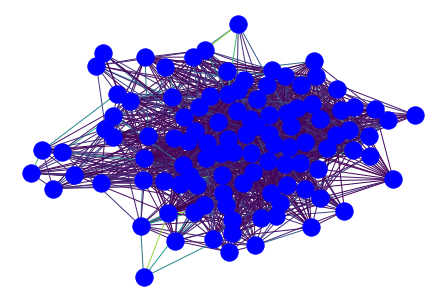

24


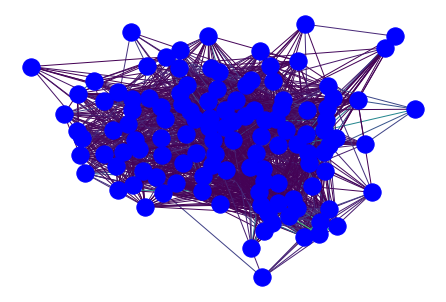

26


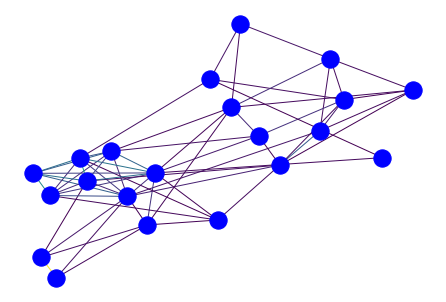

9


In [110]:
#use for Chinese Whispers:
summarize = cw_summarize

#use for TextRank:
#summarize = extract_top

prune = True
weighted_init = True

stemmer = SnowballStemmer(language='english')
tokenizer = RegexpTokenizer(r'\w+')

summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    counter = Counter()

    for s in raw_sentences:
        words = tokenizer.tokenize(s)
        sentences.append(' '.join(words))
    sentences = list(set(sentences))

    vocab = make_vocab(sentences)
    idf = compute_idf(sentences, vocab)
    vectors = [tf_idf(s, vocab, idf) for s in sentences]

    scores = []

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                scores.append((i, j, similarity(vectors[i], vectors[j])))

    if prune:
        scores = prune_graph(scores)          

    # tops of clusters obtained by PageRank
    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([sentences[i] for i in top_k])

In [111]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent + '.')
    print()

python vs java:
It s like coding in java instead of python.
Visibly faster than Python faster than Java I d bet.
Java is much more verbose than Python.
I would much rather use Python than Java.
So far I really like Python compared to Java.
Python runs slower than Java.
Python has much to offer over Java VB etc.
Python is actually older than Java.
Using the decimal library in python with 90 significant digits is massive overkill but I plan to use those results as a baseline for comparison with both the java app and the python app.
Performance is closer to Java than to Python.
Java programs are longer than their equivalent python programs.
python than for java.
Java is faster than Python every time and the optimized version of Java is twice as fast as the optimized python version.
Googling Java classes is much easier than Python.
Python is much simpler and more compact than Java.
Python might be very slow compared to C java.
Hell Python runtime is much smaller than Java or.
Aside from th

### Pretrained Language Model

Language Model inn general is a function that is fitted to maximize probabilty of the tokens sequences from some domain. In this approach we use a reccurent neural model that also learns hidden representation for every token in a given sequence that is aimed to store information about all previous words in the text. Then the next token probability is a function of a privious token representation and  a hidden state: 
$$p(x_{t+1}) = f(h_t, x_t)$$

In this experiment we use LSTM model pretrained on the set retrieved by CAM for all 512 queries. As input representations we use pretrained embeddings from BERT model with original BERT tokenizer. As our domain is pretty wide, it is efficient to use BPE tokens instead of building word-level vocabulary.

We initialize model in two different ways: randomly and by the language model pretrained on WikiText103 dataset. WikiText103 is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

As a similarity function here we use cosine distance between hidden representations of the last tokens of sentences:

$$f(h^1_{t_1}, h^2_{t_2}) = \frac {\left<h^1_{t_1}, h^2_{t_2}\right>}{\|h^1_{t_1}\|\|h^2_{t_2}\|}$$,
where $h^i$ is a sequence of hidden states of sentence $i$ and $t_i$ is number of tokens in sentence $i$.

In [0]:
# we will need BERT Tokenizer
!pip install pytorch-pretrained-bert

In [0]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from pytorch_pretrained_bert import *
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [95]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 1165161.06B/s]


Here we just load pretrained model that was initially used for Encoder-Decoder architecture. Training code can be found in MeanSum part of the project.

In [0]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp = 768, nhid = 512, nlayers=1, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear( nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, input_lengths = None):
        emb = self.drop(self.encoder(input))
        if input_lengths is not None:
            emb = torch.nn.utils.rnn.pack_padded_sequence(emb, input_lengths, enforce_sorted = True)
            outputs, hidden = self.rnn(emb, hidden)
            output, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        else:
            output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))
        

def detach_hidden(hidden):
    return (hidden[0].detach(),
            hidden[1].detach())

In [0]:
device = torch.device("cuda")

# one-layered LSTM model pretraied on CAM outputs

#LM = RNNModel(30522, nlayers=1, dropout = 0.0)
#LM.load_state_dict(torch.load('drive/My Drive/summarization/simple_lm'))

# two-layered LSTM pretrained on WikiText103 and finetuned on CAM outputs

LM = RNNModel(30522, nlayers=2, dropout = 0.0)
LM.load_state_dict(torch.load('drive/My Drive/summarization/wikitext_lm_finetuned'))

LM = LM.to(device)

In [0]:
def similarity(s1, s2):
    return s1.dot(s2)/np.linalg.norm(s1,2)/np.linalg.norm(s2, 2)

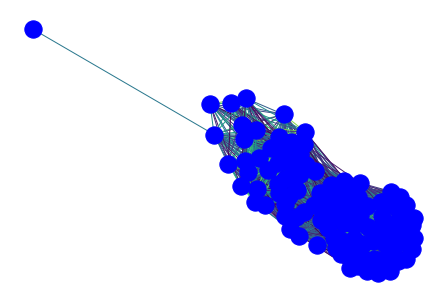

3


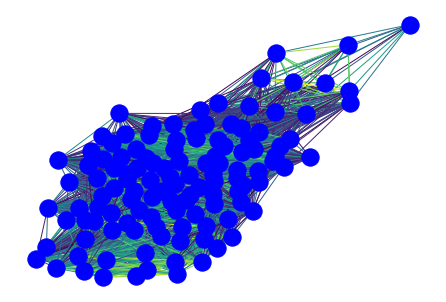

4


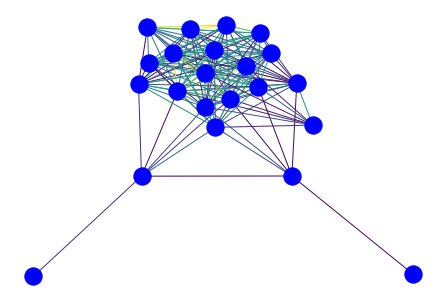

5


In [103]:
#use for Chinese Whispers:
summarize = cw_summarize

#use for TextRank:
#summarize = extract_top

prune = True
weighted_init = True

summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    for s in raw_sentences:
        s = ["[CLS]"] + tokenizer.tokenize(s) + ["[SEP]"]
        sentences.append(tokenizer.convert_tokens_to_ids(s))

    hiddens = []
    for s in sentences:
        hidden = LM.init_hidden(1)
        batch = torch.LongTensor([s]).transpose(0, 1).to(device)
        preds, h = LM(batch, hidden, input_lengths = None)
        hiddens.append(h[1].view(-1).cpu().detach().numpy())

    scores = []

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            scores.append((i, j, similarity(hiddens[i], hiddens[j])))

    if prune:
        scores = prune_graph(scores)

    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([raw_sentences[i] for i in top_k])

In [104]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent[:-1])
    print()

python vs java:
Python is easier to program in than Java.
I'm a Java kind of guy so i prefer something Java-like above python ...
Python Memory Model ------------------- Reasoning about concurrency in Python is easier than in Java.

toyota vs nissan:
Nissan was a better value than the Toyota overall.
The Nissan Pathfinder has a little less horsepower than the Toyota 4Runner.
Chevy Volt: More Toyota Prius Than Nissan Leaf .
(Business 2.0) -- Nissan has long lagged Toyota in sales.

tea vs juice:
-POM juice has more and better antioxidants than red wine, grape juice, Acai juice, and green tea!
Only problem is that this juice isn't as good as the green tea cartos.
But I was in hurry to taste her love juice first rather than tea or lichi juice etc.
Juice: Frozen orange juice is cheaper, but usually I just stick to tea and buy the GOOD orange juice for special occasions.
Variations: Top with cranberry juice instead of cola to make a Long Beach Iced Tea, orange juice instead of cola for a Ca